<a href="https://colab.research.google.com/github/felipeabe/artificial-neural-network/blob/main/trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#uploading files
from google.colab import files
uploaded = files.upload()

#importing libs
import pandas as pd

In [ ]:

# importing multiclass dataset
dfm = pd.read_csv('obesity.csv')

#changing columns names
# Defining a dictionary with old column names as keys and new column names as values
column_mapping = {
    'family_history_with_overweight': 'family_overweight',
    'FAVC': 'caloric_food',
    'FCVC': 'eat_vegetables',
    'NCP': 'meals_day',
    'SMOKE': 'smoke',
    'CH2O': 'water_day',
    'SCC': 'track_calories',
    'FAF': 'physical_activity_week',
    'CALC': 'alcohol',
    'MTRANS': 'transportation_method',
    'NObeyesdad': 'obesity_level'
}

# Renaming the columns using the dictionary
dfm = dfm.rename(columns=column_mapping)


#Removing unnecessary columns
dfm = dfm.drop(columns=['CAEC', 'TUE'])

#encoding values (binary)
binary_mappings = {
    "Gender": {"Female": 0, "Male": 1},
    "family_overweight": {"yes": 1, "no": 0},
    "caloric_food": {"yes": 1, "no": 0},
    "smoke": {"yes": 1, "no": 0},
    "track_calories": {"yes": 1, "no": 0}
}

for col, mapping in binary_mappings.items():
    dfm[col] = dfm[col].map(mapping)

#encoding alcohol usage
encoding_map = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
dfm['alcohol'] = dfm['alcohol'].map(encoding_map)


#encoding transportation_method
custom_mapping = {
    "Walking": 0,
    "Bike": 0,
    "Motorbike": 1,
    "Automobile": 1,
    "Public_Transportation": 1
}
dfm['transportation_method'] = dfm['transportation_method'].map(custom_mapping)

#encoding output column (obesity_level)
obesity_mapping = {
    "Insufficient_Weight": 0,
    "Normal_Weight": 1,
    "Overweight_Level_I": 2,
    "Overweight_Level_II": 3,
    "Obesity_Type_I": 4,
    "Obesity_Type_II": 5,
    "Obesity_Type_III": 6
}
dfm['obesity_level'] = dfm ['obesity_level'].map(obesity_mapping)

#normalizing data
columns_to_normalize = ["Height", "Weight", "Age"]
dfm[columns_to_normalize] = dfm[columns_to_normalize].apply(
    lambda x: ((x - x.min()) / (x.max() - x.min())).round(3)
)

#spliting the dataframe
#training 80% of dataset
#testing 20% of dataset
split_point = int(0.8 * len(dfm))
train_multiclass = dfm[:split_point]
test_multiclass = dfm[split_point:]


dfm.head(10)

,Gender,Age,Height,Weight,family_overweight,caloric_food,eat_vegetables,meals_day,smoke,water_day,track_calories,physical_activity_week,alcohol,transportation_method,obesity_level
0,0,0.149,0.321,0.187,1,0,2.0,3.0,0,2.0,0,0.0,0,1,1
1,0,0.149,0.132,0.127,1,0,3.0,3.0,1,3.0,1,3.0,1,1,1
2,1,0.191,0.660,0.284,1,0,2.0,3.0,0,2.0,0,2.0,2,1,1
3,1,0.277,0.660,0.358,0,0,3.0,3.0,0,2.0,0,2.0,2,0,2
4,1,0.170,0.623,0.379,0,0,2.0,1.0,0,2.0,0,0.0,1,1,3
5,1,0.319,0.321,0.104,0,1,2.0,3.0,0,2.0,0,0.0,1,1,1
6,0,0.191,0.094,0.119,1,1,3.0,3.0,0,2.0,0,1.0,1,1,1
7,1,0.170,0.358,0.104,0,0,2.0,3.0,0,2.0,0,3.0,1,1,1
8,1,0.213,0.623,0.187,1,1,3.0,3.0,0,2.0,0,1.0,2,1,1
9,1,0.170,0.509,0.216,1,1,2.0,3.0,0,2.0,0,1.0,0,1,1


Treinando modelo com Binary Cross-Entropy...
Treinamento iniciado.
Funções de ativação usadas por camada: ['relu', 'tanh', 'sigmoid']
Função de perda: binary_cross_entropy
Epoch 0/100, Loss: 0.6931
Epoch 10/100, Loss: 0.6821
Epoch 20/100, Loss: 0.6736
Epoch 30/100, Loss: 0.6669
Epoch 40/100, Loss: 0.6617
Epoch 50/100, Loss: 0.6576
Epoch 60/100, Loss: 0.6545
Epoch 70/100, Loss: 0.6520
Epoch 80/100, Loss: 0.6500
Epoch 90/100, Loss: 0.6485
Epoch 100/100, Loss: 0.6473
Treinamento concluído.
Acurácia final: 65.74%

Treinando modelo com Mean Squared Error...
Treinamento iniciado.
Funções de ativação usadas por camada: ['relu', 'tanh', 'sigmoid']
Função de perda: mse
Epoch 0/100, Loss: 0.2500
Epoch 10/100, Loss: 0.2445
Epoch 20/100, Loss: 0.2402
Epoch 30/100, Loss: 0.2369
Epoch 40/100, Loss: 0.2343
Epoch 50/100, Loss: 0.2323
Epoch 60/100, Loss: 0.2308
Epoch 70/100, Loss: 0.2296
Epoch 80/100, Loss: 0.2287
Epoch 90/100, Loss: 0.2279
Epoch 100/100, Loss: 0.2274
Treinamento concluído.
Acurácia fi

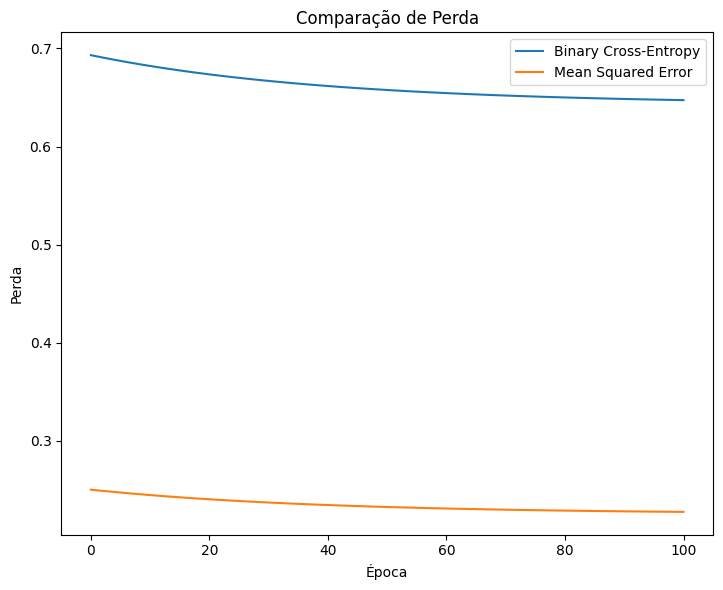

In [69]:
#import binary dataset
dfb = pd.read_csv('alzheimer.csv')
#outcome:
# 1- alzheimer
# 0- no alzheimer

#selecting useful columns
selected_columns = ['Age', 'Gender','Smoking', 'EducationLevel', 'BMI' ,'SleepQuality', 'CholesterolLDL', 'FamilyHistoryAlzheimers','PhysicalActivity', 'Diagnosis']
dfb = dfb[selected_columns]

#normalizing data
columns_to_normalize = ["BMI", "SleepQuality", "Age", "CholesterolLDL", "FamilyHistoryAlzheimers", "PhysicalActivity"]
dfb[columns_to_normalize] = dfb[columns_to_normalize].apply(
    lambda x: ((x - x.min()) / (x.max() - x.min())).round(3)
)

#spliting the dataframe
#training 80% of dataset
#testing 20% of dataset
split_point2 = int(0.8 * len(dfb))
train_binary = dfb[:split_point2]
test_binary = dfb[split_point2:]


import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Funções de ativação e derivadas
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

# Função de perda (Binary Cross-Entropy)
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Função de perda para MSE (erro quadrático médio)
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def plot_training_comparison(history_bce, history_mse):
    epochs = range(len(history_bce['loss']))

    # Gráfico de perda
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_bce['loss'], label='Binary Cross-Entropy')
    plt.plot(epochs, history_mse['loss'], label='Mean Squared Error')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.title('Comparação de Perda')
    plt.legend()


    plt.tight_layout()
    plt.show()

acuracia_final=0
class NeuralNetwork:
    def __init__(self, layers, activations, loss_function, learning_rate=0.01):
        self.layers = layers
        self.activations = activations
        self.learning_rate = learning_rate
        self.loss_functions = {
            'binary_cross_entropy': binary_cross_entropy,
            'mse': mse
        }
        if loss_function not in self.loss_functions:
            raise ValueError(f"Função de perda '{loss_function}' não suportada.")
        self.loss_function = self.loss_functions[loss_function]
        self.activation_functions = {
            'sigmoid': (sigmoid, sigmoid_derivative),
            'relu': (relu, relu_derivative),
            'tanh': (tanh, tanh_derivative)
        }
        self.weights = [np.random.randn(layers[i], layers[i - 1]) * 0.01 for i in range(1, len(layers))]
        self.biases = [np.zeros((layers[i], 1)) for i in range(1, len(layers))]
        self.history = {'loss': [], 'accuracy': []}  # Para registrar as métricas por época

    def forward(self, X):
        self.a = [X.T]  # Ativações (saídas) por camada
        self.z = []     # Soma ponderada (z = W.a + b)

        for i in range(len(self.weights)):
            z = np.dot(self.weights[i], self.a[-1]) + self.biases[i]
            self.z.append(z)
            activation_function = self.activation_functions[self.activations[i]][0]
            self.a.append(activation_function(z))

        return self.a[-1].T  # Saída final da rede

    def backward(self, X, y):
        m = X.shape[0]
        y = y.reshape(-1, 1).T
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]

        # Cálculo do erro na saída
        dz = self.a[-1] - y  # Erro na saída
        for i in reversed(range(len(self.weights))):
            dw = np.dot(dz, self.a[i].T) / m
            db = np.sum(dz, axis=1, keepdims=True) / m
            d_weights[i] = dw
            d_biases[i] = db

            if i > 0:  # Propagação do erro para trás
                activation_derivative = self.activation_functions[self.activations[i - 1]][1]
                dz = np.dot(self.weights[i].T, dz) * activation_derivative(self.z[i-1])

        # Atualização dos pesos e bias
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * d_weights[i]
            self.biases[i] -= self.learning_rate * d_biases[i]

    def train(self, X, y, epochs=100):
        print("Treinamento iniciado.")
        print(f"Funções de ativação usadas por camada: {self.activations}")
        print(f"Função de perda: {self.loss_function.__name__}")

        for epoch in range(epochs + 1):  # Inclui a época 0
            y_pred = self.forward(X)
            loss = self.loss_function(y, y_pred)
            self.history['loss'].append(loss)

            # Calcular acurácia (se aplicável)
            accuracy = np.mean((y_pred > 0.5).astype(int) == y.reshape(-1, 1))
            acuracia_final=accuracy

            self.backward(X, y)

            # Exibir progresso a cada 10 épocas
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

        print("Treinamento concluído.")
        print(f'Acurácia final: {(accuracy*100).round(2)}%')


    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int)

# Dados de treino e teste
train_data = train_binary
test_data = test_binary

X_train = train_data.drop(columns=['Diagnosis']).values
y_train = train_data['Diagnosis'].values
X_test = test_data.drop(columns=['Diagnosis']).values
y_test = test_data['Diagnosis'].values



# Treinar o primeiro modelo (Binary Cross-Entropy)
print("Treinando modelo com Binary Cross-Entropy...")
nn_bce = NeuralNetwork(
    layers=[X_train.shape[1], 10, 5, 1],
    activations=['relu', 'tanh', 'sigmoid'],
    loss_function='binary_cross_entropy',
    learning_rate=0.05
)

nn_bce.train(X_train, y_train, epochs=100)

# Treinar o segundo modelo (Mean Squared Error)
print("\nTreinando modelo com Mean Squared Error...")
nn_mse = NeuralNetwork(
    layers=[X_train.shape[1], 10, 5, 1],
    activations=['relu', 'tanh', 'sigmoid'],
    loss_function='mse',
    learning_rate=0.05
)
nn_mse.train(X_train, y_train, epochs=100)

# Avaliar o modelo com BCE
y_pred_bce = nn_bce.predict(X_test)
accuracy_bce = accuracy_score(y_test, y_pred_bce)



# Avaliar o modelo com MSE
y_pred_mse = nn_mse.predict(X_test)
accuracy_mse = accuracy_score(y_test, y_pred_mse)
print(f"Accuracy do modelo com Mean Squared Error: {accuracy_mse:.2%}")

# Plotar os gráficos de comparação
plot_training_comparison(nn_bce.history, nn_mse.history)

In [ ]:
#import regression dataset
dfr = pd.read_csv('houses.csv')

#removing columns
dfr = dfr.drop(columns=['renovated', 'quartile_zone'])

#encoding true/false
dfr = dfr.replace({True: 1, False: 0})

#Extracting the year from the data
# Convert 'date' column to datetime format
dfr['date'] = pd.to_datetime(dfr['date'])
# Extract the year and replace the original 'date' column
dfr['date'] = dfr['date'].dt.year

#normalizing data
columns_to_normalize = ["price", "living_in_m2"]
dfr[columns_to_normalize] = dfr[columns_to_normalize].apply(
    lambda x: ((x - x.min()) / (x.max() - x.min())).round(3)
)


#spliting the dataframe
#training 80% of dataset
#testing 20% of dataset
split_point3 = int(0.8 * len(dfr))
train_regression = dfr[:split_point3]
test_regression = dfr[split_point3:]

train_regression.head(10)

<ipython-input-18-1c407e60d625>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfr = dfr.replace({True: 1, False: 0})


,date,price,bedrooms,grade,has_basement,living_in_m2,nice_view,perfect_condition,real_bathrooms,has_lavatory,single_floor,month
0,2014,0.215,2,2,1,0.261,0,0,2,1,0,5
1,2014,0.213,2,2,0,0.166,0,0,1,1,0,11
2,2014,0.223,2,2,0,0.201,1,0,1,0,1,12
3,2015,0.171,2,3,0,0.299,0,0,2,1,1,2
4,2015,0.576,3,2,1,0.856,0,0,3,0,0,1
5,2015,0.339,1,2,1,0.103,1,0,1,0,1,3
6,2014,0.149,2,2,1,0.253,0,0,1,1,1,6
7,2014,0.143,1,1,0,0.264,0,0,1,0,1,10
8,2014,0.116,2,2,0,0.166,0,0,1,1,1,7
9,2014,0.432,2,3,0,0.204,0,0,2,1,0,9
